In [1]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models.segmentation.deeplabv3 as dlv3
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import utils
import data
import copy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image

## Training-related functions

In [2]:
def validate_epoch(model, device, val_dataloader, loss_function, num_classes, ignore_label):
    model.eval()
    batch_losses = []
    metrics = {'miou': 0, 'ious': np.zeros(shape=(num_classes,), dtype=np.float64), 'loss': 0}
    
    with torch.no_grad():
        for (inputs, targets) in val_dataloader:
            ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
            tgts = targets.to(device, non_blocking=True)# torch.autograd.Variable(targets).cuda()
            
            preds = model(ipts)['out']
            loss = loss_function(preds, tgts.squeeze(1).long())
            loss_val = loss.item()
            batch_losses += [loss_val]

            preds = torch.argmax(preds.cpu(), dim=1)
            tgts = torch.squeeze(targets, dim=1)

            miou, ious = utils.measure_performance(preds, tgts, num_classes=num_classes, ignore_label=ignore_label)

            metrics['ious'] += ious
            metrics['miou'] += miou
            metrics['loss'] += loss_val

        metrics['ious'] /= float(len(val_dataloader))
        metrics['miou'] /= float(len(val_dataloader))
        metrics['loss'] /= float(len(val_dataloader))
        
    return metrics

In [3]:
def train_epoch(model, device, scaler, train_dataloader, loss_function, optimizer):
    model.train()
    batch_losses = []
    
    for (inputs, targets) in train_dataloader:
        ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
        tgts = targets.to(device, non_blocking=True).squeeze(1).long() #tgts = torch.autograd.Variable(targets).cuda().squeeze(1).long()
        pred = model(ipts)['out']

        with torch.cuda.amp.autocast():
            loss = loss_function(pred, tgts)
            loss_val = loss.item()
            batch_losses += [loss_val]

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward() # loss.backward()
        scaler.step(optimizer) #optimizer.step()
        scaler.update()

    return batch_losses

In [4]:
def train(model, device, scaler, train_dataloader, val_dataloader, epochs, loss_function, optimizer, lr_initial, lr_decay, num_classes_val, ignore_label):
    model.train()

    epoch_train_losses = []
    epoch_val_losses = []
    epoch_val_mious = []
    epoch_val_ious = []

    best_model = copy.deepcopy(model.state_dict())
    best_val_miou = 0
    
    for epoch in tqdm(range(epochs), desc='Epoch progress'):

        # Training phase
        batch_train_losses = train_epoch(
            model=model, 
            device=device,
            scaler=scaler,
            train_dataloader=train_dataloader,
            loss_function=loss_function, 
            optimizer=optimizer)
        
        # Validation phase
        batch_val_metrics = validate_epoch(
            model=model,
            device=device,
            val_dataloader=val_dataloader,
            loss_function=loss_function,
            num_classes=num_classes_val,
            ignore_label=ignore_label)

        epoch_average_train_loss = np.mean(batch_train_losses)
        epoch_train_losses += [epoch_average_train_loss]
        epoch_val_losses += [batch_val_metrics['loss']]
        epoch_val_mious += [batch_val_metrics['miou']]
        epoch_val_ious += [batch_val_metrics['ious'].tolist()]

        print(f'\n[TRAIN] Epoch average loss: {epoch_average_train_loss:.4f}')
        print(f'[VAL] Epoch average loss: {batch_val_metrics["loss"]:.4f}')
        print(f'[VAL] Epoch average miou: {100 * batch_val_metrics["miou"]:.2f}%')
        
        if lr_decay:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_initial * ((1.0 - (float(epoch) / float(epochs))) ** 0.9)

        if epoch == 0 or batch_val_metrics['miou'] > best_val_miou:
            best_val_miou = batch_val_metrics['miou']
            best_model = copy.deepcopy(model.state_dict())
            print('[MODEL] Checkpoint saved.\n')

    model.load_state_dict(best_model)
    return model, {'epoch_train_losses': epoch_train_losses, 'epoch_val_losses': epoch_val_losses, 'epoch_val_mious': epoch_val_mious, 'epoch_val_ious': epoch_val_ious}

## Training configuration loading

In [5]:
import pprint
args = {}
with open('G:/My Drive/Master IVA/Master Thesis/Configs/train-config-2.json') as json_file:
    args = json.load(json_file)
pprint.pprint(args)

{'data_batch_size': 4,
 'data_source': 'real',
 'data_subset_size': 16,
 'epochs': 4,
 'fine_tune': False,
 'fine_tune_model_path': 'G:/My Drive/Master IVA/Master '
                         'Thesis/Models/20230403_210427/deeplabv3_model.pt',
 'ignore_label': 19,
 'image_height': 256,
 'image_width': 256,
 'learning_rate': 0.0005,
 'learning_rate_paper_decay': True,
 'model_save_path': 'G:/My Drive/Master IVA/Master Thesis/Models',
 'val_data_batch_size': 4,
 'val_data_subset_size': 8}


## Data loading and preprocessing

In [6]:
torch.cuda.empty_cache()
train_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=args["data_batch_size"],
                              shuffle=True)
val_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                 type=args["data_source"],
                                 labels_mapping=None)
val_dataset = Subset(val_dataset, indices=range(args["val_data_subset_size"]))
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=args["val_data_batch_size"],
                            shuffle=True)
    

In [7]:
train_pixel_sum = torch.tensor([0.0, 0.0, 0.0])
train_pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for train_inputs, _ in tqdm(train_dataloader, desc='Training dataset norm. params. comp. progress'):
    train_pixel_sum += train_inputs.sum(axis = [0, 2, 3])
    train_pixel_sum_sq += (train_inputs ** 2).sum(axis = [0, 2, 3])

train_pixel_count = args["data_subset_size"] * args["image_width"] * args["image_height"]
train_mean = train_pixel_sum / train_pixel_count
train_variance = (train_pixel_sum_sq / train_pixel_count) - (train_mean ** 2)
train_std = torch.sqrt(train_variance)

print(f'Train dataset \'mean\':{train_mean}')
print(f'Train dataset \'std deviation\':{train_std}')

val_pixel_sum = torch.tensor([0.0, 0.0, 0.0])
val_pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for val_inputs, _ in tqdm(val_dataloader, desc='Validation dataset norm. params. comp. progress'):
    val_inputs_tensor = torch.tensor(val_inputs)
    val_pixel_sum += val_inputs_tensor.sum(axis = [0, 2, 3])
    val_pixel_sum_sq += (val_inputs_tensor ** 2).sum(axis = [0, 2, 3])

val_pixel_count = args["val_data_subset_size"] * args["image_width"] * args["image_height"]
val_mean = val_pixel_sum / val_pixel_count
val_variance = (val_pixel_sum_sq / val_pixel_count) - (val_mean ** 2)
val_std = torch.sqrt(val_variance)

print(f'Validation dataset \'mean\':{val_mean}')
print(f'Validation dataset \'std deviation\':{val_std}')

Training dataset norm. params. comp. progress: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Train dataset 'mean':tensor([0.2366, 0.2782, 0.2368])
Train dataset 'std deviation':tensor([0.1392, 0.1485, 0.1444])


Validation dataset norm. params. comp. progress:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Manuel\AppData\Local\Temp\ipykernel_10624\3029786214.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs_tensor = torch.tensor(val_inputs)
Validation dataset norm. params. comp. progress: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

Validation dataset 'mean':tensor([0.3475, 0.3759, 0.3380])
Validation dataset 'std deviation':tensor([0.2413, 0.2410, 0.2390])


In [8]:
train_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std))]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=args["data_batch_size"],
                              shuffle=True, pin_memory=True, num_workers=4)
val_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.Normalize(mean=list(val_mean), std=list(val_std))]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]), 
                                 type=args["data_source"],
                                 labels_mapping=None)
val_dataset = Subset(val_dataset, indices=range(args["val_data_subset_size"]))
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=args["val_data_batch_size"],
                            shuffle=True, pin_memory=True, num_workers=4)

## Training preparation

In [9]:
model = dlv3.deeplabv3_resnet50(weights=None, output_stride=16, progress=True, num_classes=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()))
if args["fine_tune"]:
    model.load_state_dict(torch.load(args["fine_tune_model_path"]))
    for name, param in model.backbone.named_parameters():
        if 'layer1' in name or 'layer2' in name or 'layer3' in name or 'layer4' in name or 'layer5' in name:
            param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Loaded model to device.')

Loaded model to device.


In [10]:
params = utils.add_weight_decay(model, l2_value=0.0001)
optimizer = torch.optim.Adam(params=params, lr=args["learning_rate"])
loss_function = nn.CrossEntropyLoss()

## Train start

In [11]:
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()
model, train_metrics = train(model=model,
                             device=device,
                             scaler=scaler,
                             train_dataloader=train_dataloader, 
                             val_dataloader=val_dataloader, 
                             epochs=args["epochs"], 
                             loss_function=loss_function, 
                             optimizer=optimizer, 
                             lr_initial=args["learning_rate"],
                             lr_decay=args["learning_rate_paper_decay"],
                             num_classes_val=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()),
                             ignore_label=None)

Epoch progress:   0%|          | 0/4 [00:00<?, ?it/s]

(17,)
(17,)


Epoch progress:  25%|██▌       | 1/4 [00:09<00:28,  9.66s/it]


[TRAIN] Epoch average loss: 2.1415
[VAL] Epoch average loss: 1.7197
[VAL] Epoch average miou: 9.35%
[MODEL] Checkpoint saved.

(17,)
(17,)


Epoch progress:  50%|█████     | 2/4 [00:16<00:15,  7.96s/it]


[TRAIN] Epoch average loss: 1.2538
[VAL] Epoch average loss: 1.1941
[VAL] Epoch average miou: 13.34%
[MODEL] Checkpoint saved.

(17,)
(17,)


Epoch progress:  75%|███████▌  | 3/4 [00:23<00:07,  7.56s/it]


[TRAIN] Epoch average loss: 0.9576
[VAL] Epoch average loss: 0.9725
[VAL] Epoch average miou: 16.64%
[MODEL] Checkpoint saved.

(17,)
(17,)


Epoch progress: 100%|██████████| 4/4 [00:30<00:00,  7.59s/it]


[TRAIN] Epoch average loss: 0.8333
[VAL] Epoch average loss: 0.9064
[VAL] Epoch average miou: 18.16%
[MODEL] Checkpoint saved.



## Train report generation

TypeError: Object of type ndarray is not JSON serializable

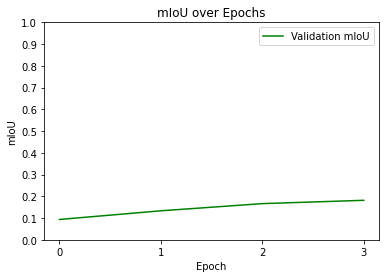

In [12]:
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y%m%d_%H%M%S")
model_save_path = f'{args["model_save_path"]}/{current_time}'
os.mkdir(model_save_path)

matplotlib.rcParams.update({'font.size': 6})

plt.plot(train_metrics['epoch_train_losses'], label='Train loss', color='blue') 
plt.plot(train_metrics['epoch_val_losses'], label='Validation loss', color='yellow') 
plt.xlabel('Epoch') 
plt.xticks(ticks=np.arange(0, args['epochs']))
plt.ylabel('Loss') 
plt.title('Loss over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/loss_over_epochs.jpg', dpi=1200)

plt.clf()
plt.plot(train_metrics['epoch_val_mious'], label='Validation mIoU', color='green') 
plt.xlabel('Epoch') 
plt.xticks(ticks=np.arange(0, args['epochs']))
plt.ylabel('mIoU') 
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.title('mIoU over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/iou_over_epochs.jpg', dpi=1200)

train_std = train_std.tolist()
train_mean = train_mean.tolist()

eval_args = {'model_load_folder_path': model_save_path,
             'train_std': train_std,
             'train_mean': train_mean,
             'data_source': "real",
             'test_subset_size': 300,
             'test_batch_size': 4,
             'ignore_label': args['ignore_label'],
             'image_width': args['image_width'],
             'image_height': args['image_height']}
eval_args = json.dumps(eval_args, indent=4)
with open(file=f'{model_save_path}/eval-config.json', mode='w') as f:
    f.write(eval_args)
    
args = json.dumps(args, indent=4)
with open(file=f'{model_save_path}/train_config.json', mode='w') as f:
    f.write(args)

train_metrics = json.dumps(train_metrics, indent=4)
with open(file=f'{model_save_path}/train_metrics.json', mode='w') as f:
    f.write(train_metrics)

torch.save(model.state_dict(), f'{model_save_path}/deeplabv3_model.pt')